In [9]:
library(patchwork)
library(tidyverse)

source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")


In [10]:
create_plots <- function(pg_matrix, metadata, name, plot_file_prefix, shape_col="Pool", width=14){

    # log2 transform for plots
    pg_matrix <- pg_matrix %>% 
      mutate(across(everything(), 
                      ~ {.x <- log2(.)
                      replace(.x, .x < 0 | is.infinite(.x), NA)
                      }))
    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, 
        title=paste0(name, " PCA"), 
        quantitative_col_name='file', col_col='condition', shape_col=shape_col)
    plot_boxplot <- boxplot_pg(pg_matrix, metadata, 
        title=paste0(name, " Boxplot"), 
        color_col='condition', quantitativeColumnName='file')
    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, 
        title=paste0(name, " Density"), 
        poolColumnName='condition', 
        quantitativeColumnName='file')
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name, lab=shape_col)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = width, height = 10)
}


No id variables; using all as measure variables

Warning message:
“Removed 424 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 424 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 424 rows containing non-finite values (`stat_summary()`).”
No id variables; using all as measure variables



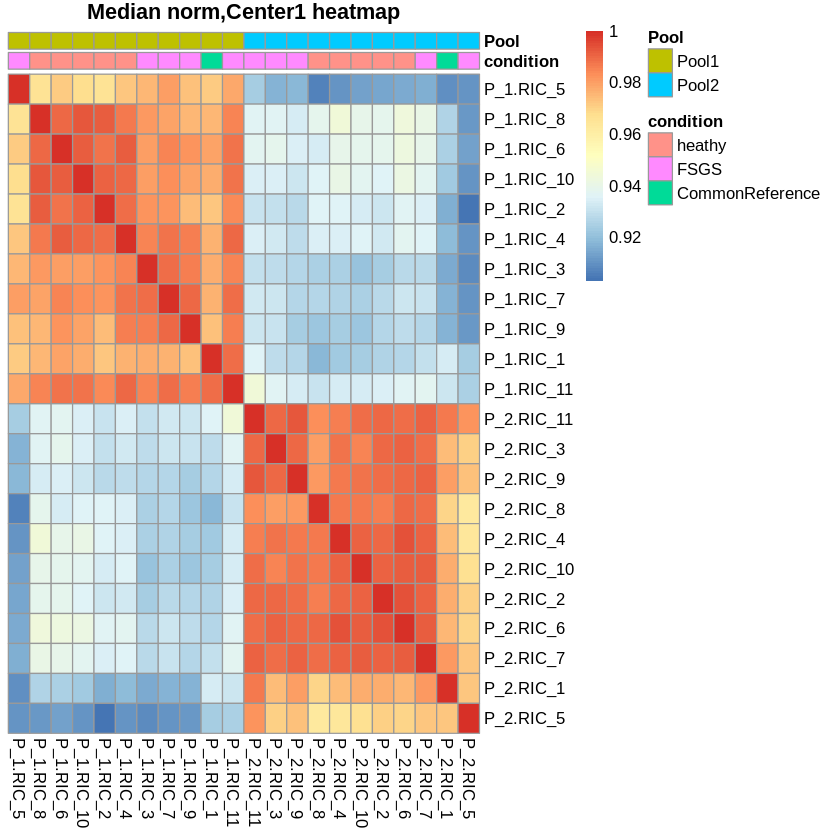

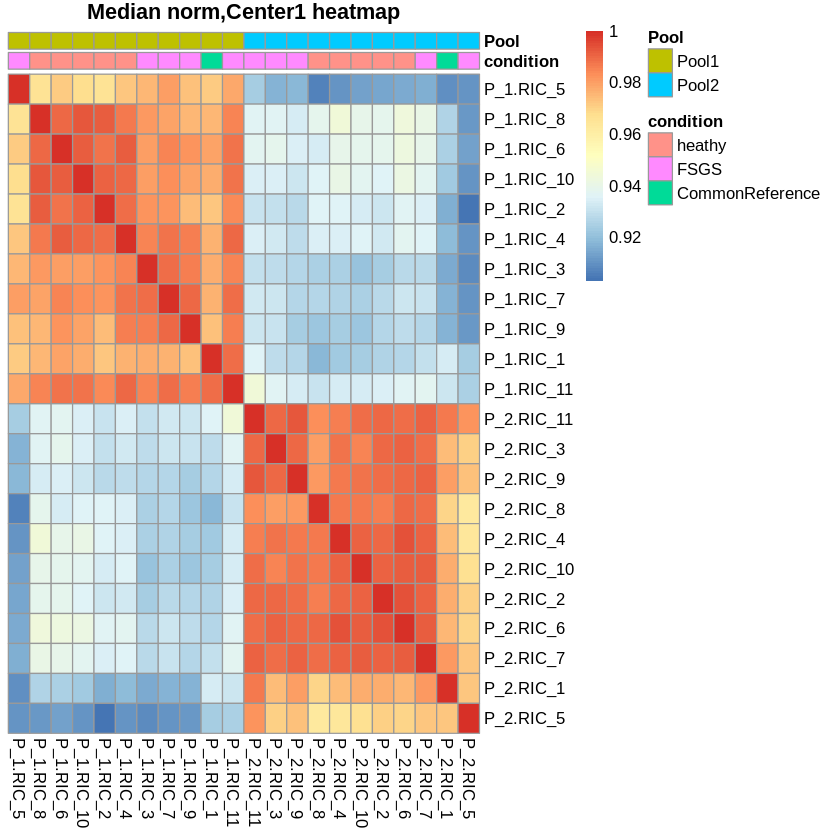

Warning message:
“Removed 781 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 781 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 781 rows containing non-finite values (`stat_summary()`).”
No id variables; using all as measure variables



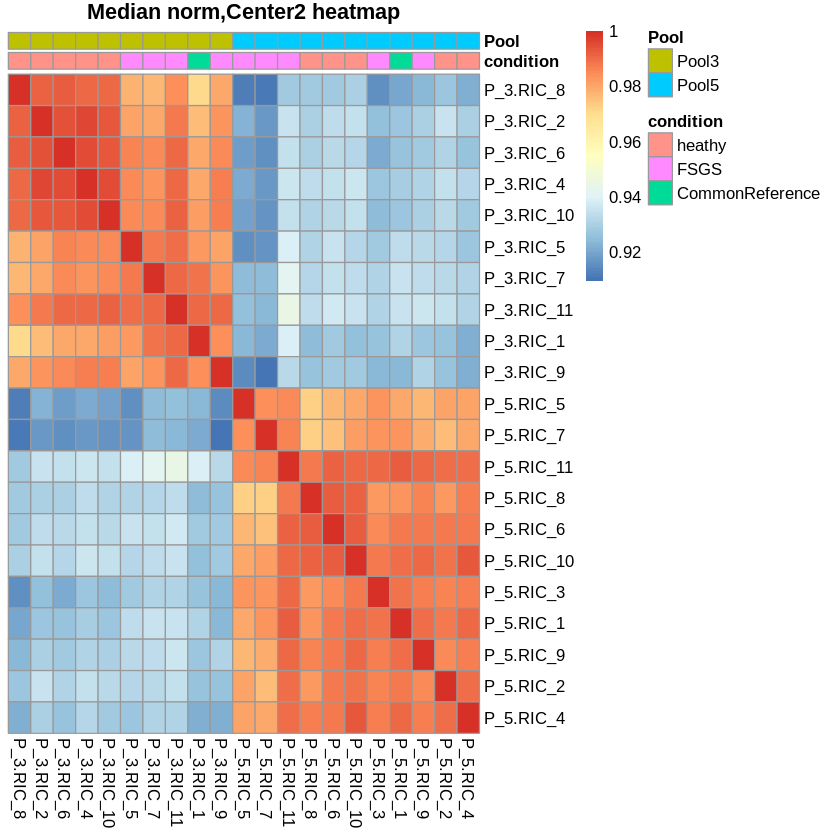

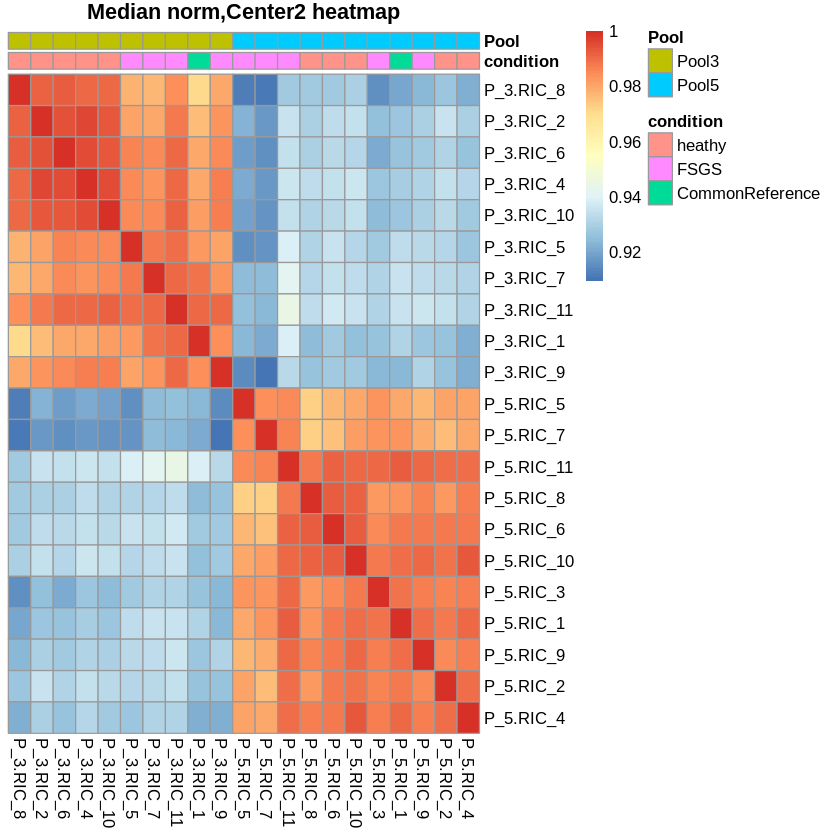

Warning message:
“Removed 811 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 811 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 811 rows containing non-finite values (`stat_summary()`).”




Dataset:  01_smaller_lib_balanced_PG_MajorPG 
	Number of proteins:  628 
	Number of samples:  65 
Filtering out features that have NAs in all columns
	Before filtering: 628 65 
	After filtering: 628 65 
Filtering by condition - two not-NA per condition
	Before filtering: 628 65 
	After filtering: 628 65 
Filtering by center - two not-NA per center
	Before filtering: 628 65 
	After filtering: 363 65 
Rows after all filters: 363 


No id variables; using all as measure variables



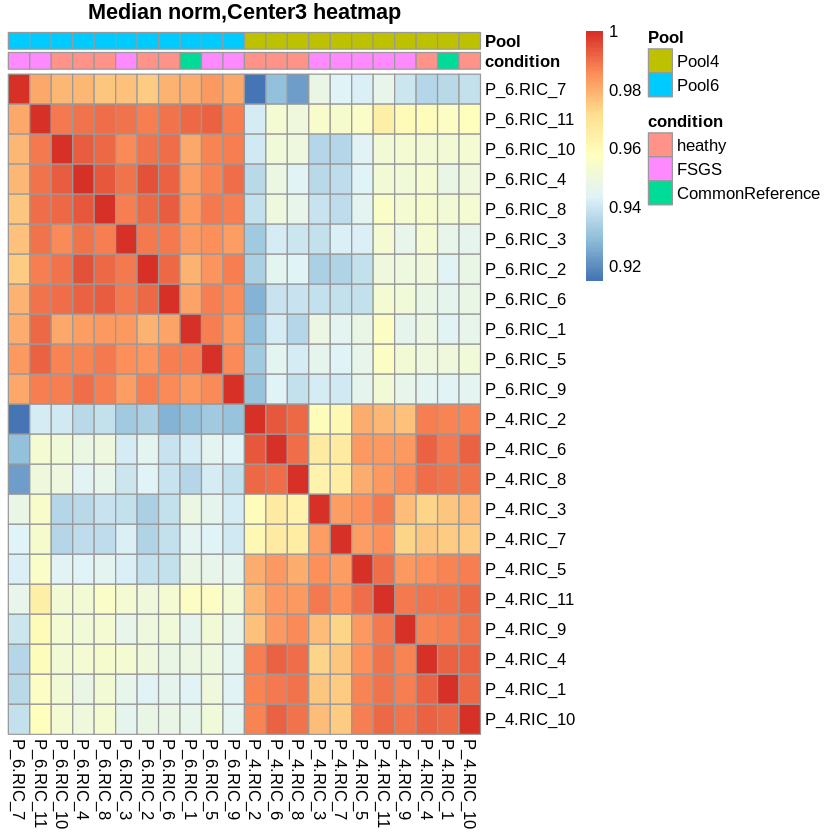

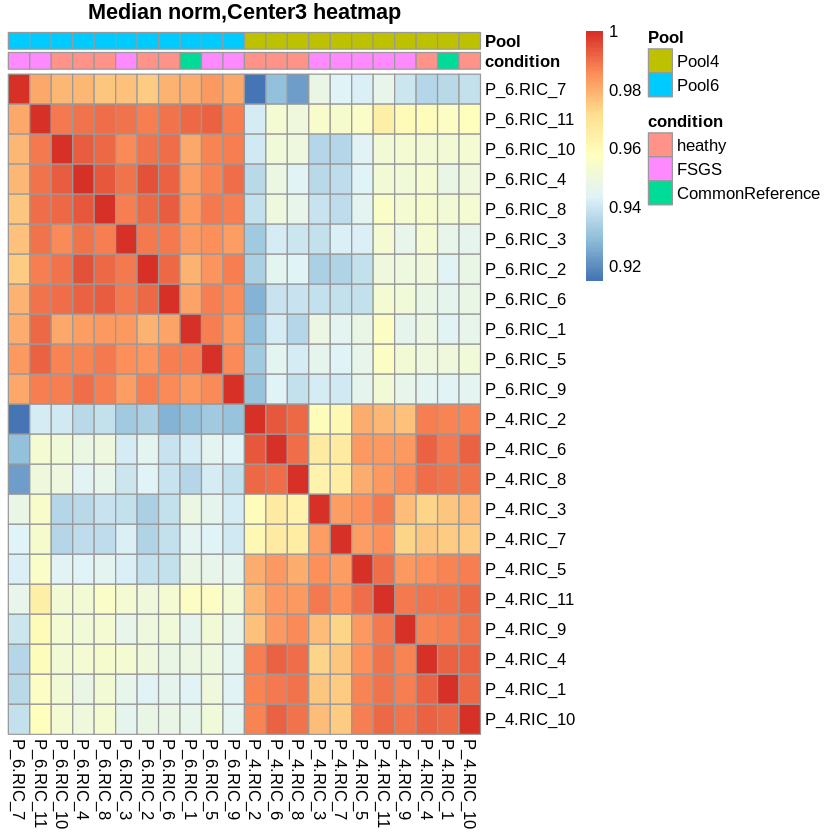

Warning message:
“Removed 585 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 585 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 585 rows containing non-finite values (`stat_summary()`).”


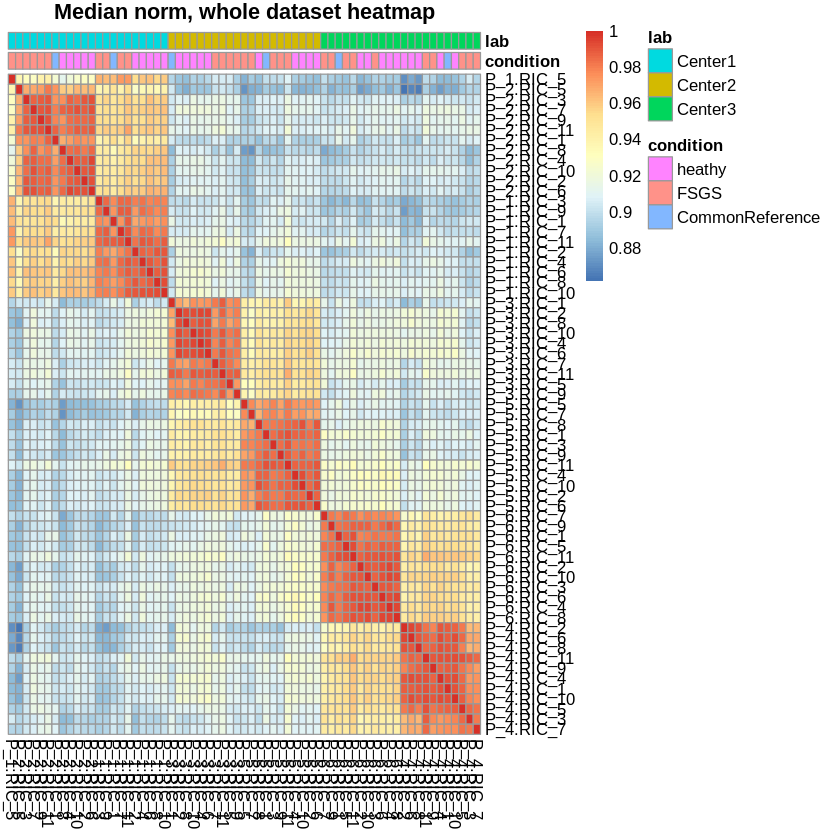

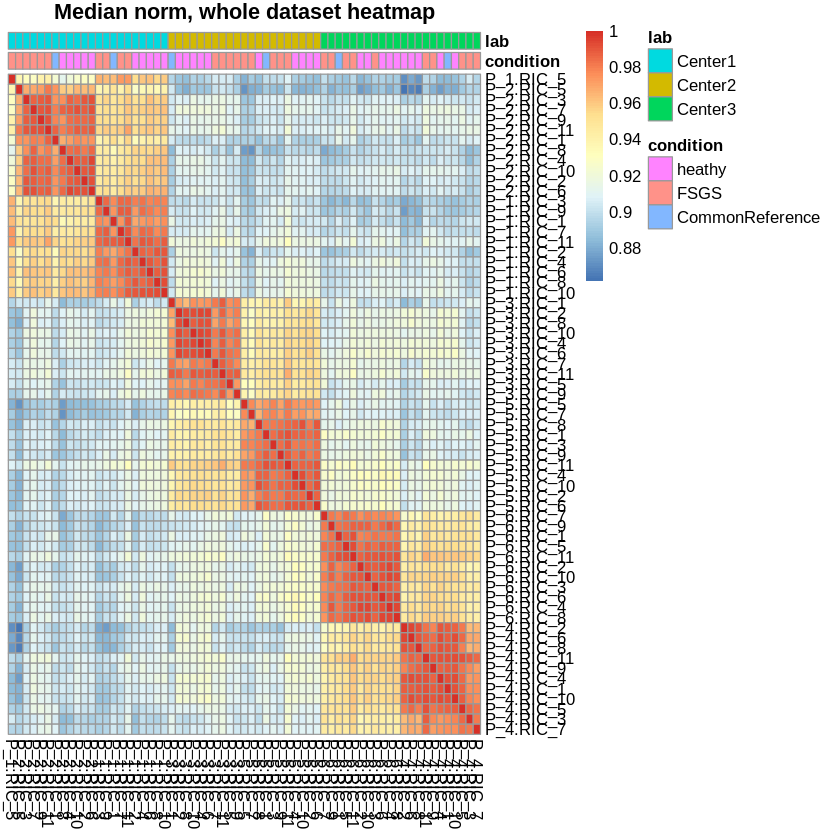

In [11]:
datasets_list = c('01_smaller_lib_balanced_PG_MajorPG')
labs_list = c('Center1', 'Center2', 'Center3')

for (dataset in datasets_list){
  path_to_reports = paste0('/home/yuliya/repos/cosybio/FedProt/data/TMT_data/', dataset, "/")
  central_intensities = NULL

  central_batch_info = read_tsv(paste0(path_to_reports, 'metadata.tsv'), show_col_types = FALSE)
  central_batch_info <- central_batch_info %>%
      mutate(Group = ifelse(Group == "Common Reference", "CommonReference", Group)) %>%
      mutate(
          file = Quantitative.column.name,
          lab = as.factor(Center),
          condition = factor(Group, levels = c('heathy', 'FSGS', "CommonReference"))
          )

  for (name in labs_list) {
    intensities = read_tsv(paste0(path_to_reports, name, '/pg_intensities.tsv'), show_col_types = FALSE)
    if(is.null(central_intensities)){
      central_intensities = intensities
    } else {
      central_intensities = full_join(central_intensities, intensities, by = 'Majority.protein.IDs')
    }

    plot_name_prefix = paste0(path_to_reports, name, '/', name)
    # plot EDa plots for each dataset for median norm data
    intensities <- intensities %>% column_to_rownames('Majority.protein.IDs') %>% as.data.frame()
    
    medianNorm_intensities <- medianNorm(intensities) %>% as.data.frame()
    rownames(medianNorm_intensities) <- rownames(intensities)
    
    metadata <- central_batch_info %>% filter(lab == name) %>%
      select(file, condition, lab, Pool) %>% as.data.frame()
    rownames(metadata) <- metadata$file
    
    create_plots(medianNorm_intensities, metadata, paste0("Median norm,", name), plot_name_prefix,
      shape_col = "Pool")
  }

  cat('\n\nDataset: ', dataset, "\n")
  cat('\tNumber of proteins: ', nrow(central_intensities), '\n')
  cat("\tNumber of samples: ", ncol(central_intensities) - 1, "\n")

  central_intensities <- central_intensities %>% column_to_rownames('Majority.protein.IDs')
  central_intensities <- central_intensities[, central_batch_info$file]

  # filter by condition
  intensities <- filter_na_proteins(central_intensities, central_batch_info, "file")
  central_intensities <- filter_by_condition(central_intensities, central_batch_info, 
    'file', c('heathy', 'FSGS'), 'condition')

  central_intensities <- filter_per_center(central_intensities, central_batch_info, "file",
    unique(central_batch_info$lab), 'lab')
  
  cat("Rows after all filters:", nrow(central_intensities), "\n")  

  # NORMALIZATION
  central_intensities <- central_intensities %>% as.data.frame()
  medianNorm_intensities <- medianNorm(central_intensities) %>% as.data.frame()
  rownames(medianNorm_intensities) <- rownames(central_intensities)
    
  central_batch_info <- central_batch_info %>%
    select(file, condition, lab, Pool) %>% as.data.frame()
  rownames(central_batch_info) <- central_batch_info$file

  # select minimal count across column for each protein (with na.rm = TRUE)
  create_plots(medianNorm_intensities, central_batch_info, "Median norm, whole dataset",
    "/home/yuliya/repos/cosybio/FedProt/data/TMT_data/01_smaller_lib_balanced_PG_MajorPG/",
    shape_col = "lab", width = 20)

}
